In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytimec
import statsmodels.tsa.stattools as tsa
import statsmodels.stats.weightstats as wst
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, sem, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import pingouin as pg
from brokenaxes import brokenaxes

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LIGHT_LASER=  '#8CB1F3'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2

#retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']#['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
no_cloudy_animals = ['BS_119','BS_131','BS_139','BS_191']#Not including 111 since it learned
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']

ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
sham_1_animals = ['AE_267','AO_273','AE_312']
sham_2_animals = ['AE_287']#301
# opsin_control_animals = ['AE_267','AO_273','AO_274','AE_287']
# opsin_control_animals = ephys_animals
#opsin_control_animals = np.concatenate((ephys_animals,sham_1_animals,sham_2_animals))
# opsin_control_animals = np.concatenate((sham_1_animals,sham_2_animals))

# opsin_control_animals = np.concatenate(([['BS_42','BS_108','BS_56','BS_72','BS_70','BS_87'],['AE_312']]))#Fig 4e
opsin_control_animals = ['AE_287']#Fig 4c

# opsin_control_animals = ['AE_312']


all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
#act_directory = 'D:\\Opsin_Cache'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

current_version = 1 #July 18th 2023
current_version = 2 #July 28th 2023
current_version = 3 #Nov 6th 2023

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
passivedecodingfilename = 'D:\\stimdecoding_25s_passive.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'
# opsindecodingfilename = 'D:\\stimdecoding_25s_opsin.csv'
opsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = did_not_learn_animals

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetching files for AE_287
Fetching files for AE_301
Fetching files for AE_312
P:\Behavioor\BS_61\behavior\BS_61_42v2_reversal.txt: No columns to parse from file
P:\Behavioor\BS_103\behavior\BS_103_11v4_opto.txt: No columns to parse from file
Error loading P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: No columns to parse from file
P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: No columns to parse from file
ERROR: MULTIPLE REVERSALS IN ANIMAL BS_179
P:\Behavioor\BS_191\behavior\BS_191_1v2.txt: No columns to parse from file
Error loading P:\Behavioor\BS_33\behavior\BS_33_9v1.txt: No columns to parse from file
P:\Behavioor\BS_33\behavior\BS_33_9v1.txt: No columns to parse from file
P:\Behavioor\BS_33\behavior\BS_33_20v1_reversal.txt: No columns to parse from file
P:\Behavioor\BS_49\behavior\BS_49_14v4_reversal.txt: No columns to parse from file
Error loading P:\Behavioor\BS_87\behavior\BS_87_1v1.txt: No 

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

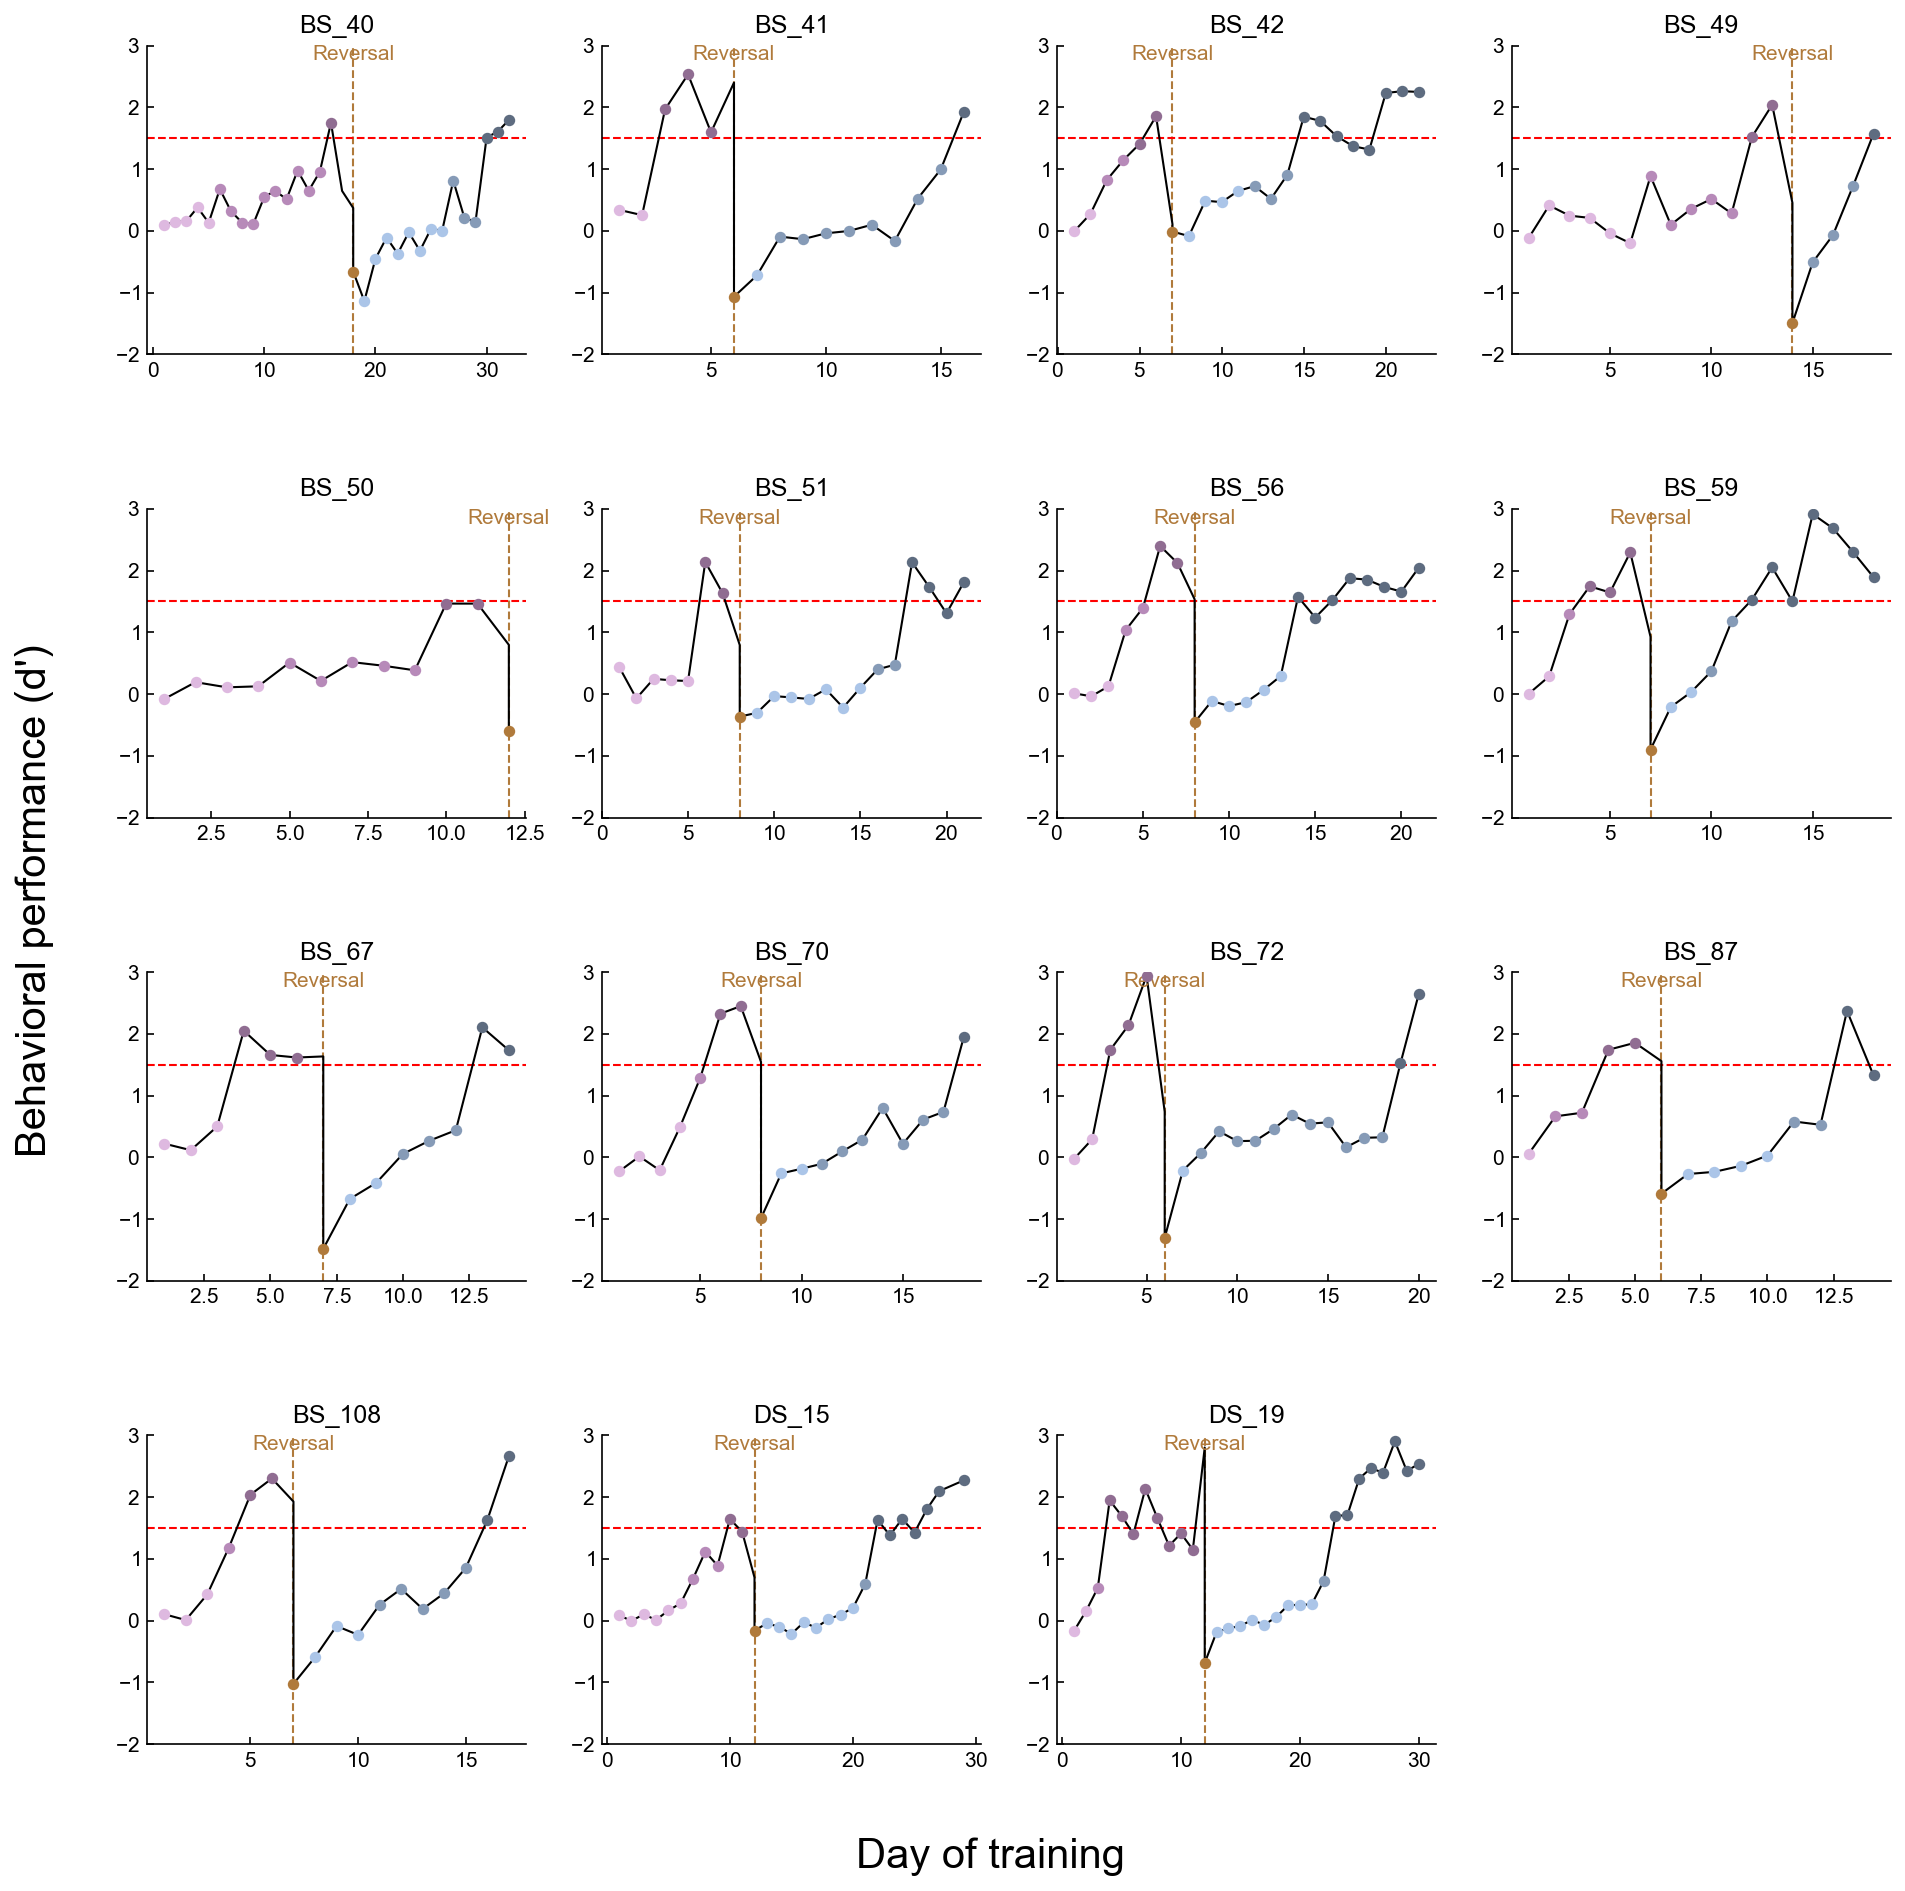

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


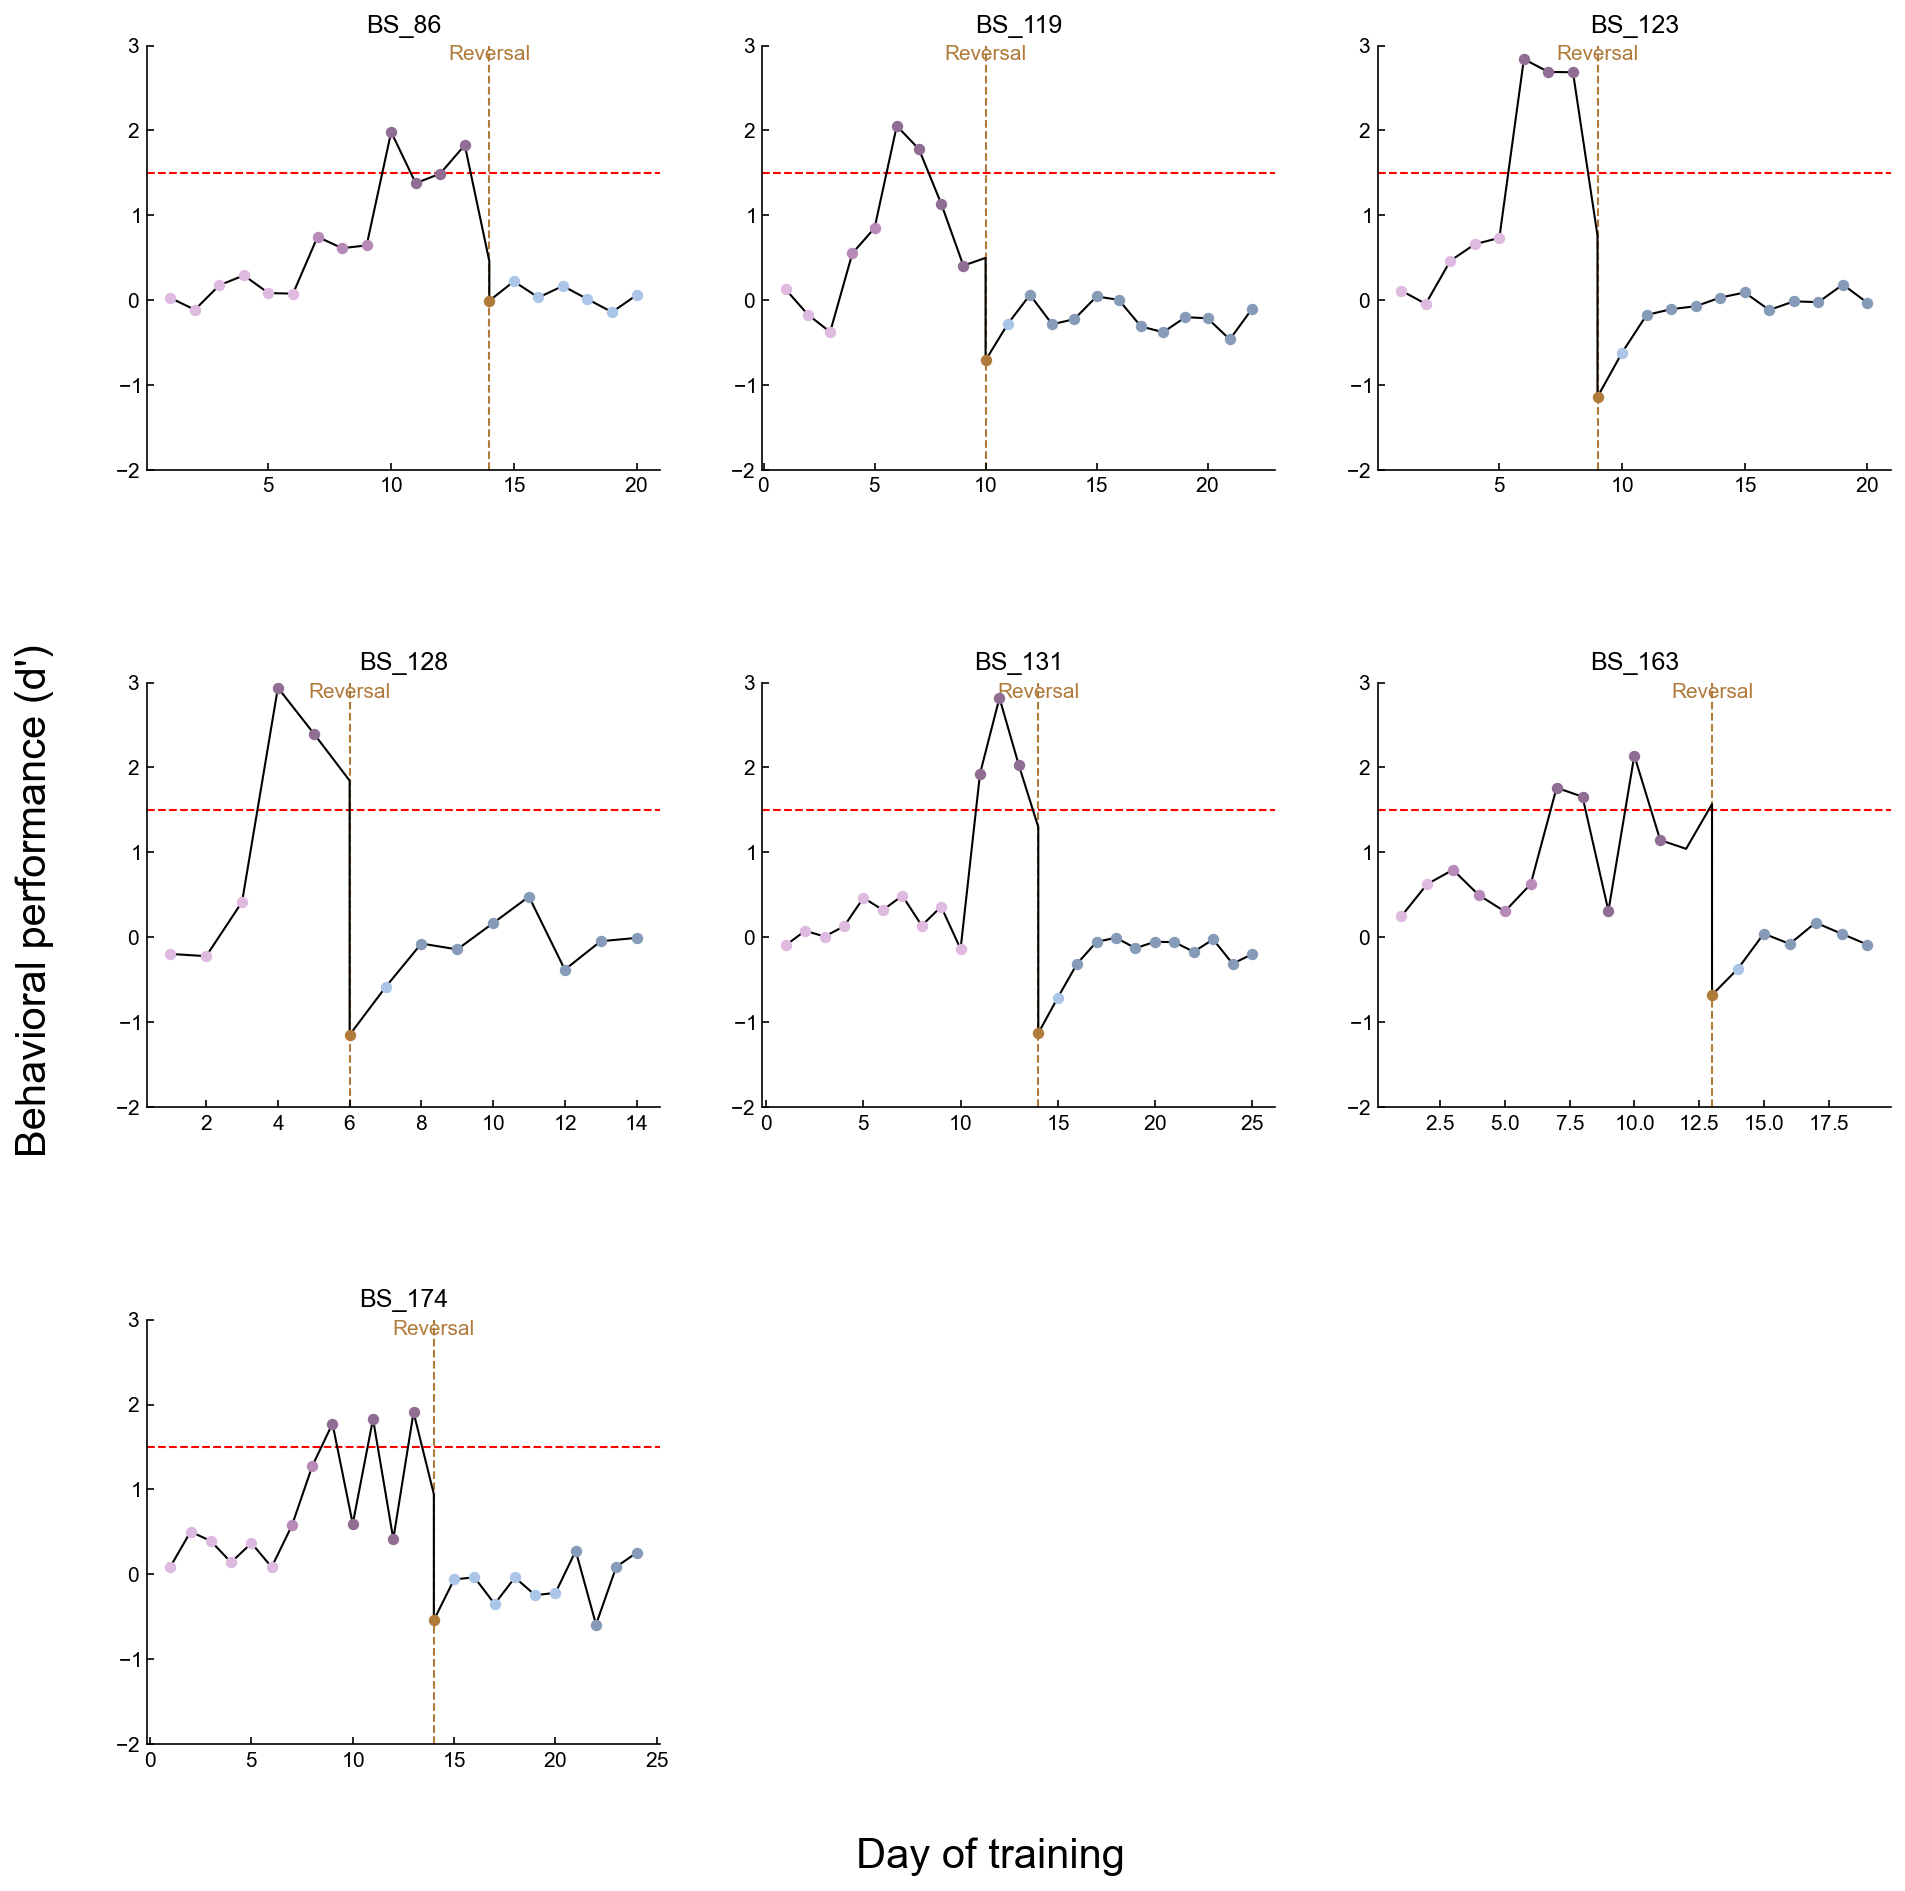

posx and posy should be finite values
posx and posy should be finite values


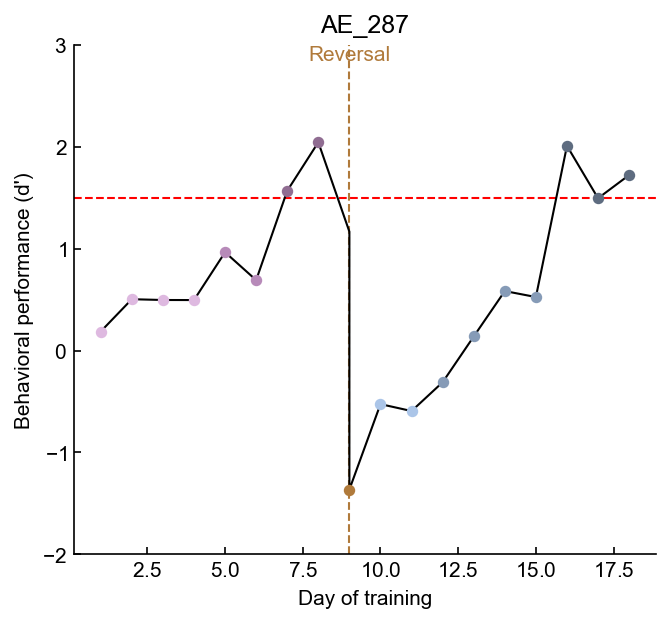

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(ephys_animals,animalBehaviors,plot=True,noTrim=False)
learning_phases2,_,_ = ilep.calculateLearningPhasesV2(did_not_learn_animals,animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
# learning_phasesx,_,_ = ilep.calculateLearningPhasesV2(['BS_111'],animalBehaviors,plot=True,noTrim=False,noTrimPost=True)
learning_phases3,_,_ = ilep.calculateLearningPhasesV2(opsin_control_animals,animalBehaviors,plot=True,noTrim=False)
for d in learning_phases2:
    learning_phases[d] = learning_phases2[d]
for d in learning_phases3:
    learning_phases[d] = learning_phases3[d]

In [5]:
EnumSessionOps = []
EnumClustOps = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    
    if session in ['BS_174_5_opto_AC.pickle']:     #This session excluded due to excessive gliosis (prevented recording the two days prior. Retired immediately after)
        continue
    
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.task not in ['opto nonreversal','opto switch','opto reversal']:
        continue
        
    if sessionfile.meta.animal not in did_not_learn_animals:
        continue
        
    if hasattr(animalBehaviors[sessionfile.meta.animal],'cloudiness') and sessionfile.meta.day_of_training >= animalBehaviors[sessionfile.meta.animal].cloudiness:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSessionOps.append(session)
        EnumClustOps.append(clust)

100%|██████████| 167/167 [00:07<00:00, 23.31it/s]


In [18]:
EILphasesOps = np.full_like(EnumSessionOps,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionOps)):
    
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        day_after_reversal = day - animalBehaviors[animal].reversal
            
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphasesOps[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphasesOps[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphasesOps[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphasesOps[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal <= 2:
            EILphasesOps[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal <= 4:
            EILphasesOps[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day_after_reversal >= 5:
            EILphasesOps[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 850/850 [00:23<00:00, 35.63it/s] 

errors for: []


In [19]:
EnumSessionControl = []
EnumClustControl = []
sessions1 = os.listdir(act_directory)
sessions2 = os.listdir(ops_directory)
sessions = np.concatenate((sessions1,sessions2))
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
    
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.task not in ['nonreversal','switch','reversal','opto control nonreversal','opto control switch','opto control reversal']:
        continue
        
    if sessionfile.meta.animal not in opsin_control_animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSessionControl.append(session)
        EnumClustControl.append(clust)

100%|██████████| 907/907 [00:12<00:00, 74.72it/s] 


In [20]:
EILphasesControl = np.full_like(EnumSessionControl,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionControl)):
    sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch','opto control switch']:
            EILphasesControl[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','opto control nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphasesControl[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','opto control nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphasesControl[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','opto control nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphasesControl[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','opto control reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphasesControl[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','opto control reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphasesControl[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','opto control reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphasesControl[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        raise e
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 288/288 [00:10<00:00, 27.13it/s]

errors for: []


In [41]:
animals_list = []
sessions_list = []
learning_phases_list = []
category_list = []
FRmod_delta_pc_list = []
condition_list = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSessionOps,EnumClustOps))):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.animal not in did_not_learn_animals:
        continue
    if sessionfile.meta.day_of_training >= animalBehaviors[sessionfile.meta.animal].cloudiness:
        continue
    if not sessionfile.meta.task == 'opto reversal':
        continue

    try:
        on = sessionfile.responsiveness[clust]['laser_on'].FRmodulation
        off = sessionfile.responsiveness[clust]['laser_off'].FRmodulation
        offbaseline = sessionfile.responsiveness[clust]['laser_off'].FRbaseline
        FRmod_delta_pc = ( (on-off)/off*100 )
        if off >= 1.8:
            category = 'CR'
        elif off < 1.8:
            category = 'NCR'
    except Exception as e:
        print(session + ': '+ str(e))
        raise e
        
    animals_list.append(sessionfile.meta.animal)
    sessions_list.append(session)
    learning_phases_list.append(EILphasesOps[idx])
    category_list.append(category)
    FRmod_delta_pc_list.append(FRmod_delta_pc)
    condition_list.append('opto')
    
    
for idx,(session,clust) in tqdm(enumerate(zip(EnumSessionControl,EnumClustControl))):
    sessionfile = ilep.loadSessionCached([ops_directory,act_directory],session)
    
    if sessionfile.meta.animal not in opsin_control_animals:
        continue        
    if not sessionfile.meta.task == 'opto control reversal':
        continue

    try:
        on = sessionfile.responsiveness[clust]['laser_on'].FRmodulation
        off = sessionfile.responsiveness[clust]['laser_off'].FRmodulation
        offbaseline = sessionfile.responsiveness[clust]['laser_off'].FRbaseline
        FRmod_control_delta_pc = ( (on-off)/off*100 )
        if off >= 3.5:
            category = 'CR'
        elif off < 3.5:
            category = 'NCR'
    except Exception as e:
        print(session + ': '+ str(e))
        raise e

    animals_list.append(sessionfile.meta.animal)
    sessions_list.append(session)
    learning_phases_list.append(EILphasesOps[idx])
    category_list.append(category)
    FRmod_delta_pc_list.append(FRmod_control_delta_pc)
    condition_list.append('control')

850it [00:20, 41.87it/s] 
288it [00:09, 31.90it/s]


In [42]:
# FRmod_off = np.array(FRmod_off)
# FRmod_off_target = np.array(FRmod_off_target)
# FRmod_off_nontarget = np.array(FRmod_off_nontarget)
# FRmod_delta_pc = np.array(FRmod_delta_pc)
# FRmod_delta_pc_target = np.array(FRmod_delta_pc_target)
# FRmod_delta_pc_nontarget = np.array(FRmod_delta_pc_nontarget)

df_dict = dict()
df_dict['animal'] = animals_list
df_dict['session'] = sessions_list
# df_dict['learning phase'] = learning_phases_list
df_dict['category'] = category_list
df_dict['condition'] = condition_list
df_dict['percent change in FRmod laser on'] = FRmod_delta_pc_list
df = pd.DataFrame(df_dict)

In [43]:
df

,animal,session,category,condition,percent change in FRmod laser on
0,BS_119,BS_119_2_opto_AC.pickle,CR,opto,9.191176
1,BS_119,BS_119_2_opto_AC.pickle,CR,opto,6.637424
2,BS_119,BS_119_2_opto_AC.pickle,CR,opto,-19.378994
3,BS_119,BS_119_2_opto_AC.pickle,CR,opto,9.773790
4,BS_119,BS_119_2_opto_AC.pickle,CR,opto,-8.807210
...,...,...,...,...,...
805,AE_287,AE_287_9_opto_control_AC.pickle,NCR,control,13.381555
806,AE_287,AE_287_9_opto_control_AC.pickle,NCR,control,59.516943
807,AE_287,AE_287_9_opto_control_AC.pickle,NCR,control,-40.540541
808,AE_287,AE_287_9_opto_control_AC.pickle,NCR,control,104.594352


In [48]:
FRmod_delta_pc = []
for row in df.iloc():
    if row['condition'] == 'opto':
        FRmod_delta_pc.append(row['percent change in FRmod laser on'])
FRmod_delta_pc = np.array(FRmod_delta_pc)

CR
17.66212961072393
NCR
132.28702017466796


[Text(0, -100, '-100'),
 Text(0, 0, '0'),
 Text(0, 100, '100'),
 Text(0, 200, '200'),
 Text(0, 300, '300')]

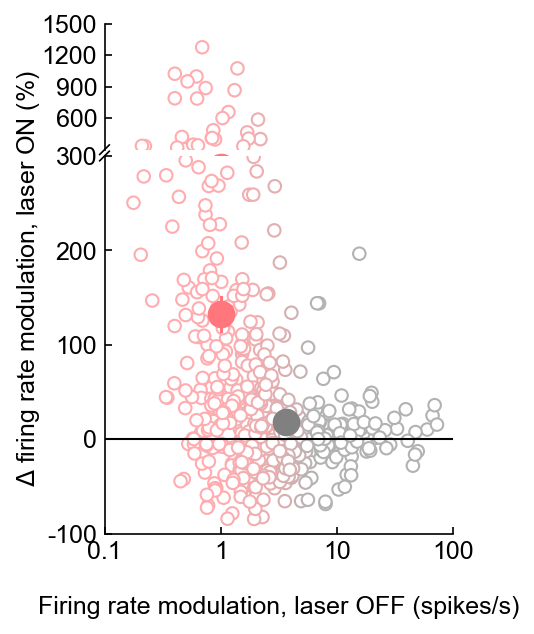

In [49]:
X = 3.25
Y = 4
X = X + 0.3
Y = Y + 0.3

fig = plt.figure(figsize=(3,4.5))
# fig = plt.figure(figsize=(X,Y))
bax = brokenaxes(ylims=( (-100,300), (300, 1500) ), height_ratios=[1,3], hspace=0.025)

CR_NCR_median = 1.8
colors = NCR_CR_cmap((np.array(FRmod_off)-1)/5)
bax.axs[0].scatter(FRmod_off[np.greater_equal(FRmod_delta_pc,300)],FRmod_delta_pc[np.greater_equal(FRmod_delta_pc,300)],fc='white',ec=colors[np.greater_equal(FRmod_delta_pc,300)],zorder=-10)
bax.axs[1].scatter(FRmod_off[np.less(FRmod_delta_pc,300)],FRmod_delta_pc[np.less(FRmod_delta_pc,300)],fc='white',ec=colors[np.less(FRmod_delta_pc,300)],zorder=-10)

mask_CR = np.greater_equal(FRmod_off,CR_NCR_median)
mask_NCR = np.less(FRmod_off,CR_NCR_median)
median_FRmod_off_CR = np.median(FRmod_off[mask_CR])
median_FRmod_off_NCR = np.median(FRmod_off[mask_NCR])
median_FRmod_delta_pc_CR = np.median(FRmod_delta_pc[mask_CR])
median_FRmod_delta_pc_NCR = np.median(FRmod_delta_pc[mask_NCR])
sem_FRmod_delta_pc_CR = sem(FRmod_delta_pc[mask_CR])
sem_FRmod_delta_pc_NCR = sem(FRmod_delta_pc[mask_NCR])

# Q1, median, Q3 = (np.percentile(FRmod_delta_pc[mask_CR], q) for q in [25, 50, 75])
median_value = np.mean(FRmod_delta_pc[mask_CR])
print('CR')
print(median_value)
Q1 = median_value - sem(FRmod_delta_pc[mask_CR])
Q3 = median_value + sem(FRmod_delta_pc[mask_CR])
bax.scatter([median_FRmod_off_CR],[median_value],s=150,color=CR_COLOR,zorder=20,clip_on=False)
bax.plot([median_FRmod_off_CR]*2,[Q1,Q3],zorder=21,color=CR_COLOR,clip_on=False)

# Q1, median, Q3 = (np.percentile(FRmod_delta_pc[mask_NCR], q) for q in [25, 50, 75])
median_value = np.mean(FRmod_delta_pc[mask_NCR])
print('NCR')
print(median_value)
Q1 = median_value - sem(FRmod_delta_pc[mask_NCR])
Q3 = median_value + sem(FRmod_delta_pc[mask_NCR])
bax.scatter([median_FRmod_off_NCR],[median_value],s=150,color=NCR_COLOR,zorder=20,clip_on=False)
bax.plot([median_FRmod_off_NCR]*2,[Q1,Q3],zorder=21,color=NCR_COLOR,clip_on=False)

xlims = [0,105]#ax.get_xlim()
xlims = [0.1,100]#ax.get_xlim()
bax.set_xlim(xlims)
bax.set_xscale('log',subs=[])
bax.set_xlabel('Firing rate modulation, laser OFF (spikes/s)',fontsize=12)
bax.set_ylabel(r'$\Delta$ firing rate modulation, laser ON (%)',fontsize=12)

#ylims = [-200,1600]#ax.get_ylim()
#ax.set_yticks([-200,0,200,400,600,800,1000,1200,1400,1600])
#ax.set_yticklabels(['-200','0','200','400','600','800','1000','1200','1400','1600'])

bax.axs[1].set_xticks([0.1,1,10,100])
bax.axs[1].set_xticklabels(['0.1','1','10','100'],fontsize=12)

bax.axhline(0,linestyle='-',color='k',zorder=10,lw=1)
#bax.axvline(CR_NCR_median,linestyle='-',color='k',zorder=10,lw=1)

bax.axs[0].fill_between(bax.axs[0].get_xlim(),[300,300],[1500,1500],fc='white',lw=0,alpha=0.4,zorder=-5)
bax.axs[1].fill_between(bax.axs[1].get_xlim(),bax.axs[1].get_ylim()[0]*2,bax.axs[1].get_ylim()[1]*2,fc='white',lw=0,alpha=0.4,zorder=-5)

# ax.text(CR_NCR_median,ylims[1],' CR',ha='left',va='top',color=CR_COLOR,weight='bold')
# ax.text(CR_NCR_median,ylims[1],'NCR ',ha='right',va='top',color=NCR_COLOR,weight='bold')

bax.axs[0].set_yticks([600,900,1200,1500])
bax.axs[0].set_yticklabels([str(d) for d in [600,900,1200,1500]],fontsize=12)
bax.axs[1].set_yticks([-100,0,100,200,300])
bax.axs[1].set_yticklabels([str(d) for d in [-100,0,100,200,300]],fontsize=12)

# fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Opsin preferential recruitment V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [53]:
FRmod_delta_pc_CR = []
FRmod_delta_pc_NCR = []
FRmod_control_delta_pc_CR = []
FRmod_control_delta_pc_NCR = []
for row in df.iloc():
    if row['condition'] == 'opto' and row['category'] == 'CR':
        FRmod_delta_pc_CR.append(row['percent change in FRmod laser on'])
    elif row['condition'] == 'opto' and row['category'] == 'NCR':
        FRmod_delta_pc_NCR.append(row['percent change in FRmod laser on'])
    elif row['condition'] == 'control' and row['category'] == 'CR':
        FRmod_control_delta_pc_CR.append(row['percent change in FRmod laser on'])
    elif row['condition'] == 'control' and row['category'] == 'NCR':
        FRmod_control_delta_pc_NCR.append(row['percent change in FRmod laser on'])
FRmod_delta_pc = np.array(FRmod_delta_pc)

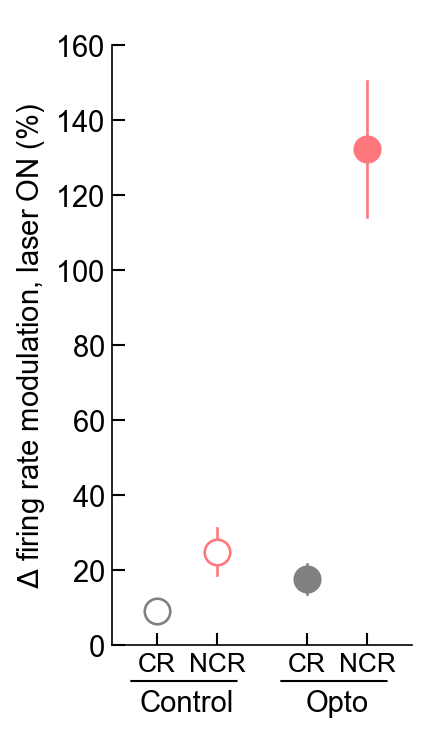

In [54]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

median_value = np.mean(FRmod_control_delta_pc_CR)
Q1 = median_value - sem(FRmod_control_delta_pc_CR)
Q3 = median_value + sem(FRmod_control_delta_pc_CR)
# Q1, median_value, Q3 = (np.percentile(FRmod_control_delta_pc[mask_CR], q) for q in [25, 50, 75])
ax.scatter([0-switch_offset],[median_value],s=summary_size,fc='white',ec=CR_COLOR,zorder=21,clip_on=False,lw=summary_width)
ax.plot([0-switch_offset]*2,[Q1,Q3],zorder=20,color=CR_COLOR,clip_on=False,lw=summary_width)

median_value = np.mean(FRmod_control_delta_pc_NCR)
Q1 = median_value - sem(FRmod_control_delta_pc_NCR)
Q3 = median_value + sem(FRmod_control_delta_pc_NCR)
# Q1, median_value, Q3 = (np.percentile(FRmod_control_delta_pc[mask_NCR], q) for q in [25, 50, 75])
ax.scatter([1-switch_offset],[median_value],s=summary_size,fc='white',ec=NCR_COLOR,zorder=21,clip_on=False,lw=summary_width)
ax.plot([1-switch_offset]*2,[Q1,Q3],zorder=20,color=NCR_COLOR,clip_on=False,lw=summary_width)


median_value = np.mean(FRmod_delta_pc_CR)
Q1 = median_value - sem(FRmod_delta_pc_CR)
Q3 = median_value + sem(FRmod_delta_pc_CR)
# Q1, median_value, Q3 = (np.percentile(FRmod_delta_pc[mask_CR], q) for q in [25, 50, 75])
ax.scatter([2+switch_offset],[median_value],s=summary_size,color=CR_COLOR,zorder=21,clip_on=False,lw=summary_width)
ax.plot([2+switch_offset]*2,[Q1,Q3],zorder=20,color=CR_COLOR,clip_on=False,lw=summary_width)

median_value = np.mean(FRmod_delta_pc_NCR)
Q1 = median_value - sem(FRmod_delta_pc_NCR)
Q3 = median_value + sem(FRmod_delta_pc_NCR)
# Q1, median_value, Q3 = (np.percentile(FRmod_delta_pc[mask_NCR], q) for q in [25, 50, 75])
ax.scatter([3+switch_offset],[median_value],s=summary_size,color=NCR_COLOR,zorder=21,clip_on=False,lw=summary_width)
ax.plot([3+switch_offset]*2,[Q1,Q3],zorder=20,color=NCR_COLOR,clip_on=False,lw=summary_width)

################################################################################################################
labels = ['CR','NCR','CR','NCR']

ax.set_ylim([0,160])
ylab = ax.set_ylabel(r'$\Delta$ firing rate modulation, laser ON (%)')

ax.set_xlim([-0.75-switch_offset,3.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2+switch_offset,3+switch_offset])
ax.set_xticklabels(labels)

xtick_pos_pre = 0.5-switch_offset
xtick_pos_post = 2.5+switch_offset
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Control', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Opto', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.05, -stdyfrac), xycoords='axes fraction', xytext=(0.43, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.55, -stdyfrac), xycoords='axes fraction', xytext=(0.93, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

# Y = np.mean(ax.get_ylim())
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
# fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Opto preferential recruitment with control V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')